# Classification and Captioning Aircraft Damage Using Pretrained Models

**Introduction**

In this project, you will classify aircraft damage using a pre-trained VGG16 model and generate captions using a Transformer-based pretrained model.

**Project Overview**

Aircraft damage detection is essential for maintaining the safety and longevity of aircraft. Traditional manual inspection methods are time-consuming and prone to human error. This project aims to automate the classification of aircraft damage into two categories: "dent" and "crack." For this, we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

**Aim of the Project**

The goal of this project is to develop an automated model that accurately classifies aircraft damage from images. By the end of the project, you will have trained and evaluated a model that utilizes feature extraction from VGG16 for damage classification. This model will be applicable in real-world damage detection within the aviation industry. Furthermore, the project will showcase how we can use a Transformer-based model to caption and summarize images, providing a detailed description of the damage.

**Final Output**

- A trained model capable of classifying aircraft images into "dent" and "crack" categories, enabling automated aircraft damage detection.
- A Transformer-based model that generates captions and summaries of images


**Objectives**

After you complete the project, you will be able to:

- Use the VGG16 model for image classification.
- Prepare and preprocess image data for a machine learning task.
- Evaluate the model’s performance using appropriate metrics.
- Visualize model predictions on test data.
- Use a custom Keras layer. 


**Task List**

To achieve the above objectives, you will complete the following tasks:

- Task 1: Create a `valid_generator` using the `valid_datagen` object
- Task 2: Create a `test_generator` using the `test_datagen` object
- Task 3: Load the VGG16 model
- Task 4: Compile the model
- Task 5: Train the model
- Task 6: Plot accuracy curves for training and validation sets 
- Task 7: Visualizing the results 
- Task 8: Implement a Helper Function to Use the Custom Keras Layer
- Task 9: Generate a caption for an image using the using BLIP pretrained model
- Task 10: Generate a summary of an image using BLIP pretrained model


## Project setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [4]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

## Extract the dataset

In [7]:
import ssl
import certifi
import urllib.request

opener = urllib.request.build_opener(
    urllib.request.HTTPSHandler(context=ssl.create_default_context(cafile=certifi.where()))
)
urllib.request.install_opener(opener)

In [8]:
import tarfile
import urllib.request
import os
import shutil

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

tar_filename = 'aircraft_damage_dataset_v1.tar'
extracted_folder = 'aircraft_damage_dataset_v1'

urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now")

if os.path.exists(extracted_folder):
  print(f"The folder '{extracted_folder}' already exists. Removing the existing folder")

  shutil.rmtree(extracted_folder)
  print(f"Removed the existing folder: {extracted_folder}")

with tarfile.open(tar_filename, 'r') as tar_ref:
  tar_ref.extractall()
  print(f"Extracted {tar_filename} successfully.")

Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now
Extracted aircraft_damage_dataset_v1.tar successfully.


In [10]:
extract_path = 'aircraft_damage_dataset_v1'
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## Data preprocessing

First,we will create ImageDataGenerators used for training, validation and testing.
The ImageDataGenerator class is part of Keras. It is a powerful utility for real-time image data augmentation, preprocessing, and feeding data into deep learning models during training. This class is particularly useful when working with image datasets that are too large to fit into memory all at once, or when you want to augment your dataset  to improve model generalization. 

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from directory and generate the training dataset
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  seed=seed_value,
  class_mode='binary',
  shuffle=True
)

Found 300 images belonging to 2 classes.


In [17]:
# Task 1: Create a valid_generator using the valid_datagen object
valid_generator = valid_datagen.flow_from_directory(
  directory = valid_dir,
  class_mode = 'binary',
  seed = seed_value,
  batch_size = batch_size,
  shuffle = False,
  target_size = (img_rows, img_cols)
)

Found 96 images belonging to 2 classes.


In [18]:
# Task 2: Create a test_generator using the test_datagen object
test_generator = test_datagen.flow_from_directory(
  directory = test_dir,
  class_mode = 'binary',
  seed = seed_value,
  batch_size = batch_size,
  shuffle = False,
  target_size = (img_rows, img_cols)
)

Found 50 images belonging to 2 classes.


## Model definition

Here, we define the model architecture by using a pre-trained VGG16 model as the base, adding custom layers on top for binary classification of 'dent' and 'crack' types of damage.

In [ ]:
# Task 3: Load the VGG16 model
base_model = VGG16(
  weights = 'imagenet',
  include_top = False,
  input_shape = (img_rows, img_cols, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Now, we modify the VGG16 model for our specific classification task. We extract the output from the last layer of the pre-trained VGG16 model, and then create a new model with this modified output. Then we will freeze the base VGG16 model layers so that their weights will not be updated during training.

In [21]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
  layer.trainable = False


After using VGG16 as a feature extractor, we add our own classifier on top of the VGG16 model. This involves adding fully connected layers (Dense), activation functions (like ReLU), and sometimes Dropout layers to avoid overfitting. Here, we are adding two dense layers with 512 units each, followed by a Dropout layer, and finally, a Dense layer with one unit and a sigmoid activation to output the probability for binary classification ("dent" vs "crack").

In [22]:
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [24]:
# Task 4: Compile the model
model.compile(
  optimizer = Adam(learning_rate=0.0001),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

## Model training

In [37]:
# Task 5: Model training
history = model.fit(
  train_generator,
  epochs = n_epochs,
  validation_data = valid_generator,
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9933 - loss: 0.0371 - val_accuracy: 0.7604 - val_loss: 0.5773
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9967 - loss: 0.0402 - val_accuracy: 0.7708 - val_loss: 0.4996
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 0.7500 - val_loss: 0.5375
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9933 - loss: 0.0298 - val_accuracy: 0.7396 - val_loss: 0.5279
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9967 - loss: 0.0269 - val_accuracy: 0.7500 - val_loss: 0.5527


In [38]:
train_history = model.history.history

## Visualizing training results

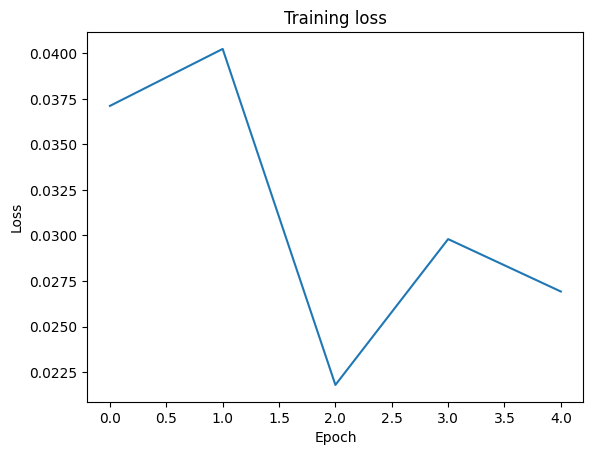

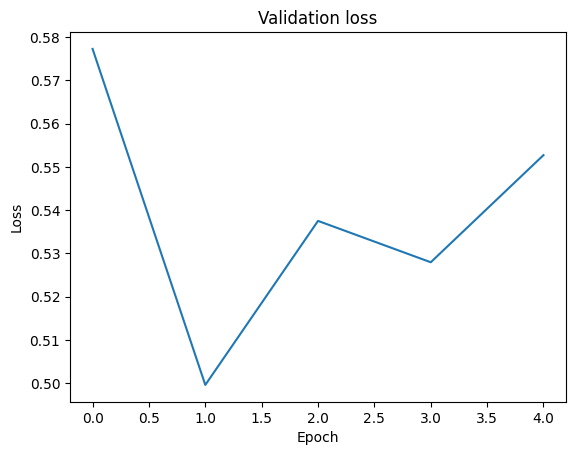

In [39]:
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

Text(0, 0.5, 'Accuracy')

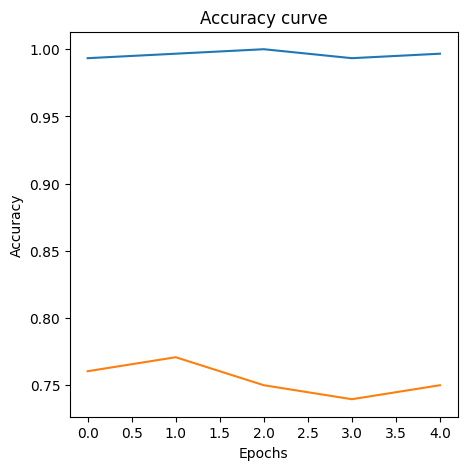

In [ ]:
# Task 6: Plot accuracy curves for training and validation sets 
plt.figure(figsize=(5,5))
plt.plot(train_history['accuracy'], label='Training accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Model evaluation

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracty: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8125 - loss: 0.8994
Test loss: 0.8994
Test accuracty: 0.8125


## Visualizing predictions

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def plot_image_with_title(image, model, true_label, predicted_label, class_names):
  plt.figure(figsize=(6, 6))
  plt.imshow(image)

  true_label_name = class_names[true_label]
  pred_label_name = class_names[predicted_label]

  plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
  plt.axis('off')
  plt.show()

def test_model_on_image(test_generator, model, index_to_plot=0):
  test_images, test_labels = next(test_generator)

  predictions = model.predict(test_images)
  predicted_classes = (predictions > 0.5).astype(int).flatten()

  class_indices = test_generator.class_indices
  class_names = {v: k for k, v in class_indices.items()}

  image_to_plot = test_images[index_to_plot]
  true_label = test_labels[index_to_plot]
  predicted_label = predicted_classes[index_to_plot]

  plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


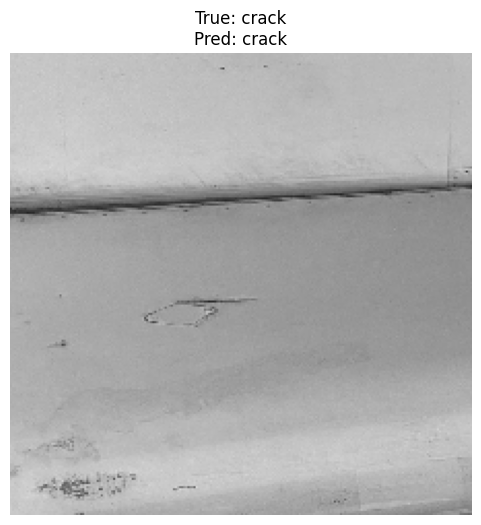

In [47]:
# Task 7: Visualizing the results
test_model_on_image(
  test_generator,
  model,
  index_to_plot=1)

## Image captioning and summarization using BLIP pretrained model

BLIP (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, learners will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.


**Key Steps:**

- **Image Loading and Preprocessing:** The code will begin by loading images from a file path, then converting and processing them into a format suitable for input to the BLIP model.
  
- **Text Generation:** Depending on the task, whether generating a caption or summary, the BLIP model will generate corresponding text based on the processed image.
  
- **Custom Keras Layer:** A custom Keras layer is a user-defined layer that extends Keras' built-in functionality.Here custom Keras layer will be implemented to wrap the BLIP model. This layer will handle the task-specific processing (captioning or summarizing) and integrate smoothly into a TensorFlow/Keras environment.


In [51]:
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

In [52]:
processor = BlipProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
model = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Custom Keras Layer: BlipCaptionSummaryLayer


Next, we define a custom `tf.keras.layers.Layer` class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model. To create a custom Keras layer, we need to subclass `tf.keras.layers.Layer` and implement the required methods.

**BlipCaptionSummaryLayer Class:**

This custom Keras layer integrates image preprocessing and text generation using a pretrained BLIP model.

- **`__init__`**: This constructor method initializes the `BlipCaptionSummaryLayer` class by setting up the BLIP processor and model.
  
- **`call`**: This method defines the operations or transformations applied to the input data as it passes through the layer.

- **`process_image`**: The `process_image` method contains the custom logic for loading the image, preprocessing it, generating the text (either a caption or a summary) using the BLIP model, and returning the generated result.


In [53]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
  def __init__(self, processor, model, **kwargs):
    """
    Initialize the custom Keras layer with the BLIP processor and model.

    Args:
        processor: The BLIP processor for preparing inputs for the model.
        model: The BLIP model for generating captions or summaries.
    """
    super().__init__(**kwargs)
    self.processor = processor
    self.model = model

  def call(self, image_path, task):
    # Use tf.py_function to run the custom image processing and text generation
    return tf.py_function(self.process_image, [image_path, task], tf.string)

  def process_image(self, image_path, task):
    """
    Perform image loading, preprocessing, and text generation.

    Args:
        image_path: Path to the image file as a string.
        task: The type of task ("caption" or "summary").

    Returns:
        The generated caption or summary as a string.
    """
    try:
      image_path_str = image_path.numpy().decode('utf-8')
      image = Image.open(image_path_str).convert('RGB')

      if task.numpy().decode('utf-8') == 'caption':
        prompt = 'This is a picture of'
      else:
        prompt = 'This is a detailed photo showing'
      
      inputs = self.processor(images=image, text=prompt, return_tensors='pt')
      output = self.model.generate(**inputs)

      result = self.processor.decode(output[0], skip_special_tokens=True)
      return result
    except Exception as e:
      print(f"Error: {e}")
      return 'Error processing image'

In [54]:
# Task 8: Implement a helper function to use the custom keras layer
def generate_text(image_path, task):
  blip_layer = BlipCaptionSummaryLayer(processor, model)
  return blip_layer(image_path, task)

### Generating captions and summaries

In [55]:
image_path = tf.constant('aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg')

caption = generate_text(image_path, tf.constant('caption'))
print('Caption:', caption.numpy().decode('utf-8'))

summary = generate_text(image_path, tf.constant('summary'))
print('Summary:', summary.numpy().decode('utf-8'))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


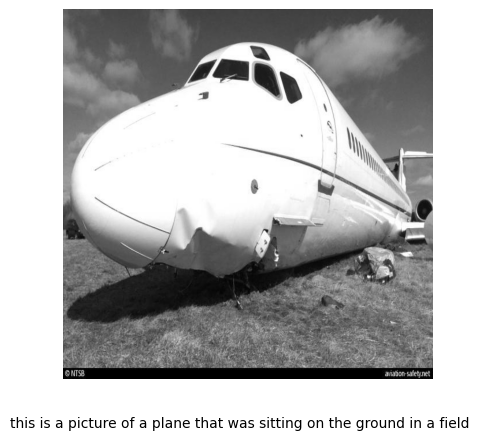

In [61]:
# Task 9: Generate a caption for an image using the BLIP pretrained model
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"

image_path = tf.constant(image_url)
caption = generate_text(image_path, tf.constant('caption'))

img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')
plt.figtext(0.5, 0.01, caption.numpy().decode('utf-8'), ha='center')
plt.show()

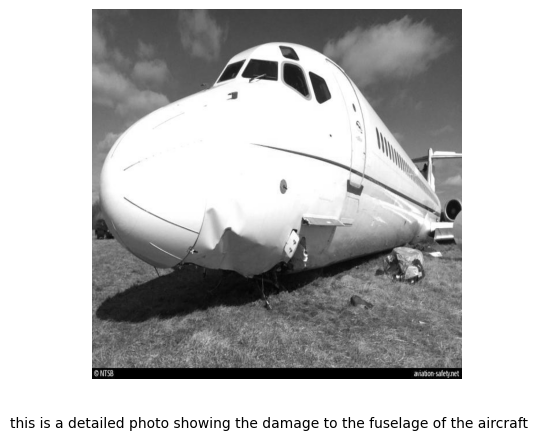

In [64]:
# Task 10: Generate a summary of an image using BLIP pretrained model
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"

image_path = tf.constant(image_url)
summary = generate_text(image_path, tf.constant('summary'))

img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')
plt.figtext(0.5, 0.01, summary.numpy().decode('utf-8'), ha='center')
plt.show()